<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Bartian/melk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To initialize Apache Spark, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!wget -q http://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
os.environ["PYTHON"] = os.environ["SPARK_HOME"] + "/python"
import findspark
findspark.init()
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Window
from pyspark.sql.functions import last
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import date
import sys
from google.colab import drive, files
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

# Initialise stuff
sp = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

fileName = 'ff_dairy_v1.csv'
if not os.path.isfile(fileName):
  uploaded = files.upload()

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(fileName)
milk_data = spark.read.csv(SparkFiles.get(fileName), header=True)
milk_data = milk_data.repartitionByRange("Cow number")
newColumnNames = list(map(lambda x: x.replace(".","").replace("�C","degC").replace("�I","plusI"), milk_data.columns))

milk_data = milk_data.toDF(*newColumnNames)

def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, F.col(colName).cast(dataType))

# Preparing Lists with the colum names and which type they need to be
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']

columns_to_remove = ['Date', 'Period (VP = preperiod, HP = trial period)', 'Barn', 'Week', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH']
for column in columns_to_remove:
  allColumns.remove(column)
  # Try except ValueError because not every column is in every list
  try: 
    doubleColumns.remove(column)
  except ValueError:
    pass
  try: 
    intColumns.remove(column)
  except ValueError:
    pass
  try: 
    stringColumn.remove(column)
  except ValueError:
    pass
  milk_data = milk_data.drop(column)

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_data = fixType(milk_data, colName, "double")
for colName in intColumns:
  milk_data = fixType(milk_data, colName, "int")

# Forward fill blank values
# define the window
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_data.columns:
  # define the forward-filled column
  filled_column = last(milk_data[column], ignorenulls=True).over(window)

  # do the fill 
  milk_data = milk_data.withColumn(column,  filled_column)

milk_data = milk_data.withColumn("Milk yield next day", F.lead("Milk yield (kg)", 1).over(Window.partitionBy('Cow number').orderBy('Day number')))
intColumns.remove('Cow number')
milk_data = milk_data.drop('Cow number')


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/mai

Saving ff_dairy_v1.csv to ff_dairy_v1.csv


In [105]:
milk_data.select('Milk yield (kg)', 'Milk yield next day').show(10)

+---------------+-------------------+
|Milk yield (kg)|Milk yield next day|
+---------------+-------------------+
|          29.35|              30.26|
|          30.26|              30.74|
|          30.74|              27.74|
|          27.74|              27.95|
|          27.95|              31.62|
|          31.62|              29.24|
|          29.24|              28.31|
|          28.31|              25.38|
|          25.38|              28.55|
|          28.55|              30.11|
+---------------+-------------------+
only showing top 10 rows



In [99]:
predictionColName = 'predicted Milk yield'
labelColName = "Milk yield next day"
inputColNames = [f'{col}_encoded' for col in stringColumn] + doubleColumns + intColumns
# inputColNames.remove(labelColName)

milk_data = milk_data.dropna() #subset=inputColNames+[labelColName])

# # Split dataset into test and training data
train_data, test_data = milk_data.randomSplit([0.8, 0.2], 0)

# Stages for pipeline
# Index string columns
index_strings = StringIndexer(inputCols = stringColumn, outputCols= [f'{col}_index'for col in stringColumn])

# Encode string columns
encoder = OneHotEncoder(inputCols=index_strings.getOutputCols(), 
                                 outputCols= [f'{col}_encoded' for col in stringColumn])

# Vectorize input columns
vectorizer = VectorAssembler(
    inputCols = inputColNames,
    # inputCols = inputColNames,
    outputCol = "features")

# standardizer = StandardScaler(True, True)

lr = LinearRegression(featuresCol = 'features', labelCol=labelColName, predictionCol = predictionColName)

# Create pipeline
lr_pipeline = Pipeline(stages = [index_strings, encoder, vectorizer, lr])

# Fit pipeline
lr_model = lr_pipeline.fit(train_data)



# standardizer.fit(lr_model).transform(lr_model)
# scaled_features_matrix = RowMatrix(lr_model.select('features').rdd.map(lambda x: x[0].tolist()))
# pca = scaled_features_matrix.computePrincipalComponents(5)
# vectorized = vectorizer.transform(milk_data) #.select('features', 'Protein%')
# test_data, train_data = vectorized.randomSplit([0.8, 0.2], 0)
# lr_model = lr.fit(train_data)



In [107]:
# Inspecting the results of the previous model
# The coefficients (i.e., weights) are as follows:
# weights = lr_model.stages[-1].coefficients
# weights_list = list(zip(inputColNames, weights))
# weights_list.sort(key=lambda tup: abs(tup[1]), reverse=True)
# Print coefficients 
# list(zip(inputColNames, weights))
print(weights_list)
 
#  # Print the intercept
# print("Intercept: ",lr_model.stages[-1].intercept)

[('Concentrate intake (kg)', -2.8589462201896274), ('Air speed', -2.662460199546413), ('Water intake (kg)', -2.111857311441087), ('Barn part', -2.055582542773407), ('Intake total ration (kg dm)', -1.7783645146884812), ('Lactation number', -1.7568089184335045), ('ECM preperiod (kg)', 1.5631854585018068), ('nXP (g/kg dm)', 1.3256963407635087), ('Intake pre-period (kg dm)', -1.0277614879263), ('Max temperature (degC)', -0.962208545222427), ('ECM (kg)', -0.86650063420486), ('Treatment_encoded', 0.7231345287564295), ('Na (g/kg dm)', 0.519354040394953), ('Day number', 0.4911922229047476), ('K (g/kg dm)', 0.489246954461791), ('EKB (g/kg dm)', 0.4619558970950031), ('Urea (mg/kg)', -0.3275900785783133), ('Protein preperiod (kg)', 0.30385855150724045), ('Cl (g/kg dm)', 0.30221685151023775), ('Period part (VP = preperiod, HP = trial period)_encoded', 0.29336695770860477), ('P (g/kg dm)', 0.29273563769906413), ('Mg (g/kg dm)', -0.29092756506012524), ('Starch (g/kg dm)', 0.2705893582891745), ('Inta

In [102]:
# Model Predictions:

 # Apply our LR model to the test data and predict output
predictionsLR = lr_model.transform(test_data)#.select(inputColNames + [labelColName] + [predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

+----------+---------+---------+----------------+------------+----------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+---------+----------+---------------------+---------------+-----------------------+-------------------+----------------+------------+-----------+------------+---------

In [41]:
print(lr_model.extractParamMap())

{}


Root Mean Squared Error: 4.130870256377159
r2: 0.6213039421349454


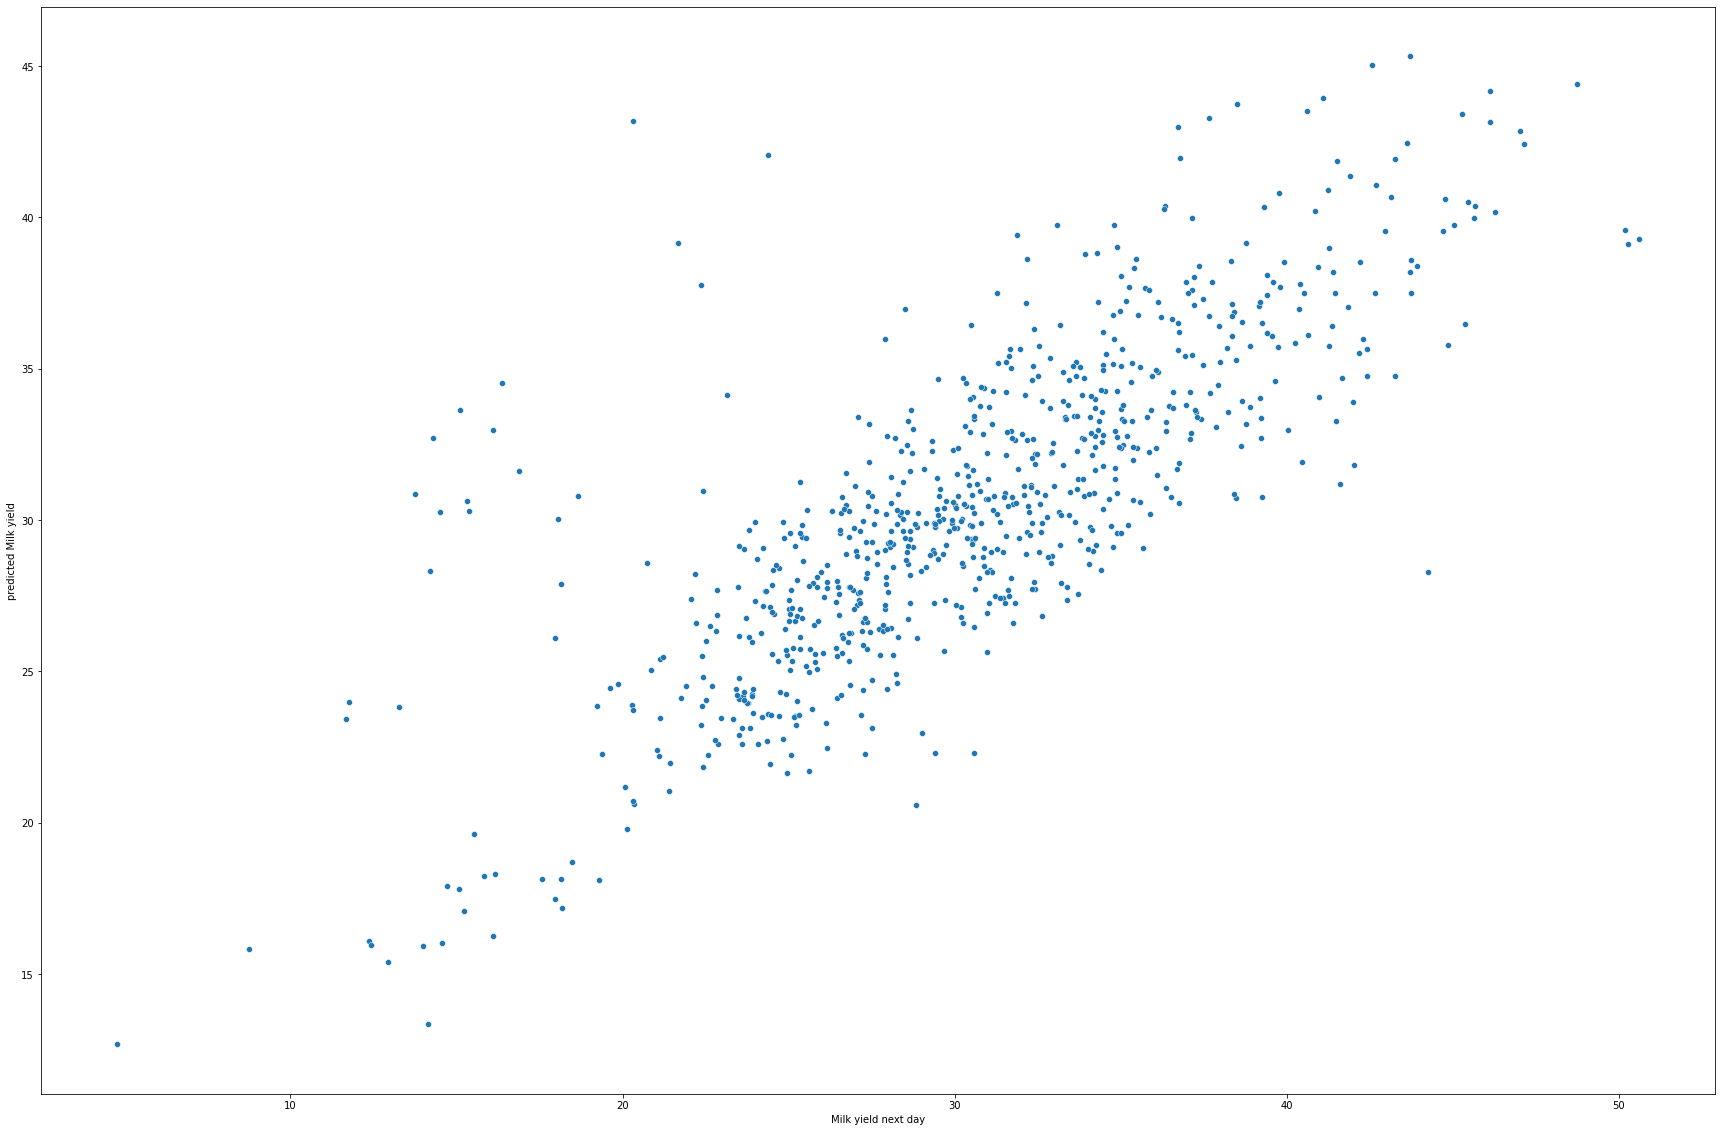

In [106]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

 # Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

 # Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

print(f"Root Mean Squared Error: {rmse}")

# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

print(f"r2: {r2}")
sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas())

In [51]:
## Use paramater tuning to try to create a better linear regression model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lr_pipeline, evaluator=regEval, numFolds=3)

# Tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11, 2)]

# Create a paramter grid using the ParamGridBuilder,
# and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Find and return the best model
cvModel = crossval.fit(train_data).bestModel